In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.random as tf_r
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras
import numpy as np

np.random.seed(12345)
tf_r.set_seed(12345)

mpl.rc('image', cmap='copper')
plt.rcParams['font.size'] = 15

In [16]:
# the same old 'f' function but now it accepts arrays of shape (n, 2)
def func(x, c=1):
    if c == 1:
        mask1 = (x[:, 0] > -25) & (x[:, 1] > -35) & (x[:, 0] + x[:, 1] < 30)
        mask2 = (x[:, 0] + x[:, 1]) > 50
        mask = np.logical_or(mask1, mask2)
    elif c == 2:
        mask = np.sign(x[:, 0] - 0.2 * x[:, 1]) * np.cos(np.linalg.norm(x, axis=1) / (1.5 * np.pi))
    else:
        mask = np.zeros(shape=len(x))

    return mask.astype(int)


def filename(s, typ=1):
    return f"./DATA/{s}-for-DNN-{typ}.dat"


def generate_data_file(n, b, typ):
    # print(np.random.randint(0, 10, size=3))

    x = (np.random.random(size=(n, 2)) - 0.5) * b
    y = func(x, c=typ)

    fn = filename("data", typ)
    np.savetxt(fn, x)

    fn = filename("labels", typ)
    np.savetxt(fn, y, fmt="%d")

First 10 datas:
[-23.57463757  43.99293127] 1
[ 43.44051776 -20.40380652] 1
[-38.76477928 -13.32914479] 0
[-29.21747789 -33.18603801] 0
[26.09995848 13.71212265] 0
[ 12.06056168 -37.39026942] 0
[ -7.61501059 -10.51026314] 1
[12.98118407 26.49596705] 0
[-47.88423622  35.4717139 ] 0
[38.59469392 -2.32997099] 0


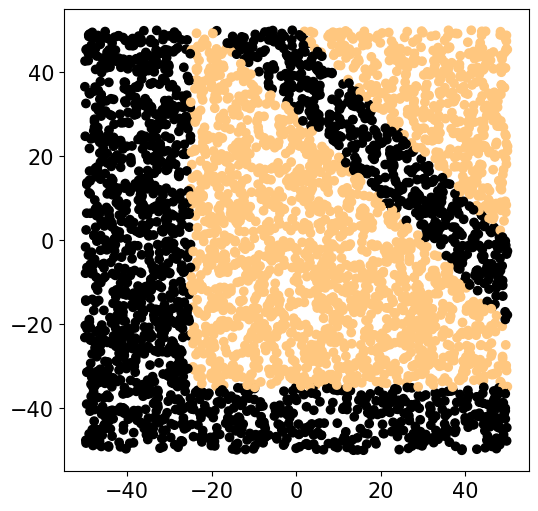

In [21]:
B = 100
TYPE = 1
N = 4000

generate_data_file(n=N, b=B, typ=TYPE)
x = np.loadtxt(filename("data", TYPE), delimiter=' ')
y = np.loadtxt(filename("labels", TYPE), delimiter=' ')
L = x.shape[1]

print("First 10 datas:")
for i in range(10):
    print(x[i, :], int(y[i]))

plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], c=y);


In [25]:
perc_train = 0.8
N_train = int(perc_train * N)

# We normalize the data
# x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
x = x / np.std(x, axis=0)

x_train, y_train = x[0:N_train], y[0:N_train]
x_valid, y_valid = x[N_train:], y[N_train:]

print("Data:", len(x), "\tTrain:", len(x_train), "\tValidation:", len(x_valid))


Data: 4000 	Train: 3200 	Validation: 800


In [26]:
# Here we define our model
def compile_model(optimizer, dropout_rate, output_dim=2):
    print("opt", optimizer, "rate", dropout_rate, "out_dim", output_dim)
    model = Sequential()
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='sigmoid'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

# print(model.summary())


In [27]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

batch_size = 50
n_epochs = 10
model_gridsearch = KerasClassifier(build_fn=compile_model, epochs=n_epochs, batch_size=batch_size, verbose=2)

# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['Adam', "Adamax"]
dropout_rates = [0, 0.01, 0.1]
param_grid = {"optimizer": optimizer, "dropout_rate": dropout_rates}

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

y_train_cat = keras.utils.to_categorical(y_train, 2)
grid_result = grid.fit(x_train, y_train_cat)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


C:\Users\Emanuele\AppData\Local\Temp\ipykernel_15400\894206801.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=compile_model, epochs=n_epochs, batch_size=batch_size, verbose=2)


opt Adam rate 0.1 out_dim 2
Epoch 1/10
64/64 - 4s - loss: 0.6817 - accuracy: 0.5853 - 4s/epoch - 67ms/step
Epoch 2/10
64/64 - 0s - loss: 0.6639 - accuracy: 0.6225 - 201ms/epoch - 3ms/step
Epoch 3/10
64/64 - 0s - loss: 0.6510 - accuracy: 0.6322 - 199ms/epoch - 3ms/step
Epoch 4/10
64/64 - 0s - loss: 0.6389 - accuracy: 0.6422 - 196ms/epoch - 3ms/step
Epoch 5/10
64/64 - 0s - loss: 0.6328 - accuracy: 0.6459 - 218ms/epoch - 3ms/step
Epoch 6/10
64/64 - 0s - loss: 0.6246 - accuracy: 0.6672 - 150ms/epoch - 2ms/step
Epoch 7/10
64/64 - 0s - loss: 0.6203 - accuracy: 0.6669 - 138ms/epoch - 2ms/step
Epoch 8/10
64/64 - 0s - loss: 0.6184 - accuracy: 0.6691 - 172ms/epoch - 3ms/step
Epoch 9/10
64/64 - 0s - loss: 0.6105 - accuracy: 0.6778 - 160ms/epoch - 3ms/step
Epoch 10/10
64/64 - 0s - loss: 0.6075 - accuracy: 0.6794 - 188ms/epoch - 3ms/step
Best: 0.760000 using {'dropout_rate': 0.1, 'optimizer': 'Adam'}
0.753438 (0.050089) with: {'dropout_rate': 0, 'optimizer': 'Adam'}
0.732500 (0.032799) with: {'drop

In [28]:

best_parameters = {"optimizer": "Adam", "dropout_rate": 0}

# See how to performances changes when N is reduced
total_data_ratios = np.array([0.9, 0.75, 0.5, 0.3])
total_data_N = np.round(len(x) * total_data_ratios).astype(int)

# something is wrong with this code, because the loss it's always zero, and the accuracy is the same (and < 0.5)
for N in total_data_N:
    x_cut, y_cut = x[0:N], y[0:N]
    N_train = int(perc_train * N)
    x_train, y_train = x_cut[0:N_train], y_cut[0:N_train]
    x_valid, y_valid = x_cut[N_train:], y_cut[N_train:]
    model = compile_model(**best_parameters, output_dim=1)
    fit = model.fit(x_train, y_train, epochs=50, batch_size=50, validation_data=(x_valid, y_valid), verbose=1)
    print(fit.history)
    print("N:", N, "validation accuracy:", fit.history['val_accuracy'])

    # print(fit)
    break


opt Adam rate 0 out_dim 1
Epoch 1/50
58/58 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4771 - val_loss: 0.0000e+00 - val_accuracy: 0.4583
Epoch 2/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.4910 - val_loss: 0.0000e+00 - val_accuracy: 0.4583
Epoch 3/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.4910 - val_loss: 0.0000e+00 - val_accuracy: 0.4583
Epoch 4/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.4910 - val_loss: 0.0000e+00 - val_accuracy: 0.4583
Epoch 5/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.4910 - val_loss: 0.0000e+00 - val_accuracy: 0.4583
Epoch 6/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.4910 - val_loss: 0.0000e+00 - val_accuracy: 0.4583
Epoch 7/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - a